In [1]:
pip install tensorflow==2.12.0


Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install seaborn

Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras import models
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf

2024-11-20 16:05:15.995145: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 16:05:15.997768: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 16:05:16.045269: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 16:05:16.046481: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
# to share the GPU resources for multiple sessions
import tensorflow as tf
from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True # dynamically grow the memory used on the GPU
config.log_device_placement = True # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)

%matplotlib inline

2024-11-20 16:04:49.065454: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-20 16:04:49.067960: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 16:04:49.115919: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-20 16:04:49.117020: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
my_data_dir = './dataset/cell_images'
os.listdir(my_data_dir)

['test', 'train']

In [4]:
test_path = my_data_dir+'/test/'
train_path = my_data_dir+'/train/'

In [5]:
os.listdir(train_path)
len(os.listdir(train_path+'/uninfected/'))
len(os.listdir(train_path+'/parasitized/'))
os.listdir(train_path+'/parasitized')[200]

'C189P150ThinF_IMG_20151203_141004_cell_73.png'

In [6]:
para_img= imread(train_path+
                 '/parasitized/'+
                 os.listdir(train_path+'/parasitized')[200])


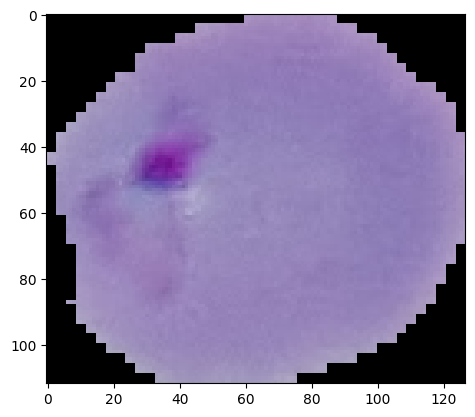

In [7]:
plt.imshow(para_img)

In [8]:
# Checking the image dimensions
dim1 = []
dim2 = []
for image_filename in os.listdir(test_path+'/uninfected'):
    img = imread(test_path+'/uninfected'+'/'+image_filename)
    d1,d2,colors = img.shape
    dim1.append(d1)
    dim2.append(d2)

Help on class ImageDataGenerator in module keras.preprocessing.image:

class ImageDataGenerator(builtins.object)
 |  ImageDataGenerator(featurewise_center=False, samplewise_center=False, featurewise_std_normalization=False, samplewise_std_normalization=False, zca_whitening=False, zca_epsilon=1e-06, rotation_range=0, width_shift_range=0.0, height_shift_range=0.0, brightness_range=None, shear_range=0.0, zoom_range=0.0, channel_shift_range=0.0, fill_mode='nearest', cval=0.0, horizontal_flip=False, vertical_flip=False, rescale=None, preprocessing_function=None, data_format=None, validation_split=0.0, interpolation_order=1, dtype=None)
 |  
 |  Generate batches of tensor image data with real-time data augmentation.
 |  
 |  Deprecated: `tf.keras.preprocessing.image.ImageDataGenerator` is not
 |  recommended for new code. Prefer loading images with
 |  `tf.keras.utils.image_dataset_from_directory` and transforming the output
 |  `tf.data.Dataset` with preprocessing layers. For more informati

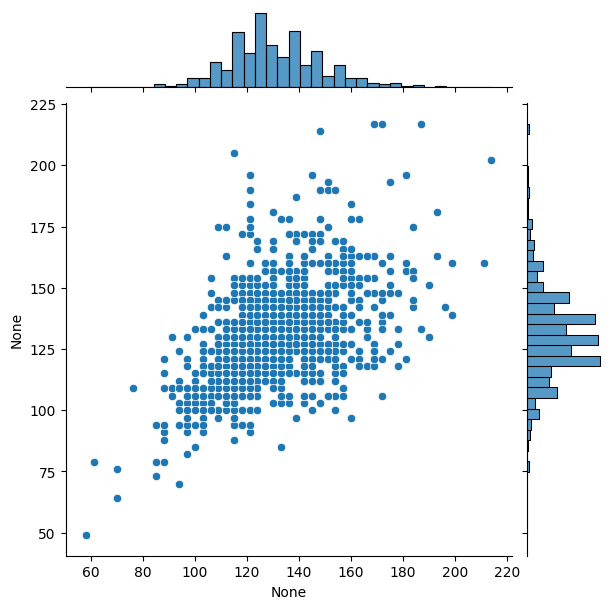

In [9]:
sns.jointplot(x=dim1,y=dim2)
image_shape = (130,130,3)
help(ImageDataGenerator)

In [10]:
image_gen = ImageDataGenerator(rotation_range=20, # rotate the image 20 degrees
                               width_shift_range=0.10, # Shift the pic width by a max of 5%
                               height_shift_range=0.10, # Shift the pic height by a max of 5%
                               rescale=1/255, # Rescale the image by normalzing it.
                               shear_range=0.1, # Shear means cutting away part of the image (max 10%)
                               zoom_range=0.1, # Zoom in by 10% max
                               horizontal_flip=True, # Allo horizontal flipping
                               fill_mode='nearest' # Fill in missing pixels with the nearest filled value
                              )

In [11]:
image_gen.flow_from_directory(train_path)
image_gen.flow_from_directory(test_path)

Found 24958 images belonging to 2 classes.
Found 2600 images belonging to 2 classes.


In [12]:
model = models.Sequential()

2024-11-20 16:05:55.404523: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:996] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-11-20 16:05:55.408793: W tensorflow/core/common_runtime/gpu/gpu_device.cc:1956] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


In [13]:
# Add convolutional layers
model.add(layers.Conv2D(filters=32, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

model.add(layers.Conv2D(filters=64, kernel_size=(3,3),input_shape=image_shape, activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))

# Flatten the layer
model.add(layers.Flatten())

# Add a dense layer
model.add(layers.Dense(128, activation='relu'))

# Output layer
model.add(layers.Dense(1, activation='sigmoid'))


In [14]:
model.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 31, 31, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 29, 29, 64)        36928     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 64)       0

In [15]:
batch_size = 16
help(image_gen.flow_from_directory)
train_image_gen = image_gen.flow_from_directory(train_path,
                                               target_size=image_shape[:2],
                                                color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary')

Help on method flow_from_directory in module keras.preprocessing.image:

flow_from_directory(directory, target_size=(256, 256), color_mode='rgb', classes=None, class_mode='categorical', batch_size=32, shuffle=True, seed=None, save_to_dir=None, save_prefix='', save_format='png', follow_links=False, subset=None, interpolation='nearest', keep_aspect_ratio=False) method of keras.preprocessing.image.ImageDataGenerator instance
    Takes the path to a directory & generates batches of augmented data.
    
    Args:
        directory: string, path to the target directory. It should contain
          one subdirectory per class. Any PNG, JPG, BMP, PPM or TIF images
          inside each of the subdirectories directory tree will be included
          in the generator. See [this script](
          https://gist.github.com/fchollet/0830affa1f7f19fd47b06d4cf89ed44d)
          for more details.
        target_size: Tuple of integers `(height, width)`, defaults to `(256,
          256)`. The dimensions

In [16]:
train_image_gen.batch_size
len(train_image_gen.classes)
train_image_gen.total_batches_seen

0

In [17]:
test_image_gen = image_gen.flow_from_directory(test_path,
                                               target_size=image_shape[:2],
                                               color_mode='rgb',
                                               batch_size=batch_size,
                                               class_mode='binary',shuffle=False)

Found 2600 images belonging to 2 classes.


In [18]:
train_image_gen.class_indices

{'parasitized': 0, 'uninfected': 1}

In [19]:
results = model.fit(train_image_gen,epochs=3,
                              validation_data=test_image_gen
                   )

Epoch 1/3


2024-11-20 16:06:27.999266: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1560/1560 [==============================] - ETA: 0s - loss: 0.4137 - accuracy: 0.7885

2024-11-20 16:08:13.851605: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


1560/1560 [==============================] - 116s 73ms/step - loss: 0.4137 - accuracy: 0.7885 - val_loss: 0.3268 - val_accuracy: 0.9031
Epoch 2/3
1560/1560 [==============================] - 115s 73ms/step - loss: 0.1975 - accuracy: 0.9381 - val_loss: 0.1790 - val_accuracy: 0.9431
Epoch 3/3
1560/1560 [==============================] - 114s 73ms/step - loss: 0.1666 - accuracy: 0.9478 - val_loss: 0.1681 - val_accuracy: 0.9446


In [20]:
model.save('cell_model.h5')

Swetha S
212222230155



<Axes: >

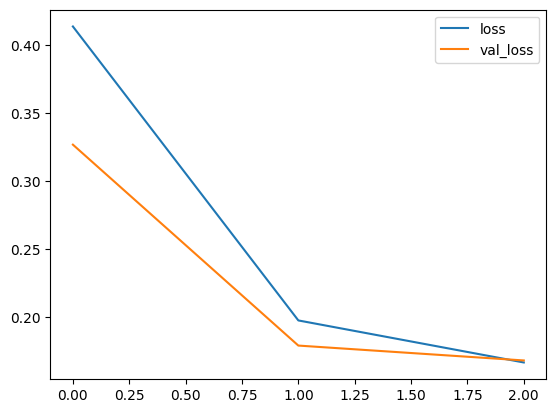

In [21]:
losses = pd.DataFrame(model.history.history)
print("Swetha S\n212222230155\n")
losses[['loss','val_loss']].plot()

In [22]:
model.metrics_names


['loss', 'accuracy']

In [23]:
print("Swetha S\n212222230155\n")
model.evaluate(test_image_gen)

Swetha S
212222230155

  2/163 [..............................] - ETA: 10s - loss: 0.0215 - accuracy: 1.0000

2024-11-20 16:12:33.533577: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


163/163 [==============================] - 10s 63ms/step - loss: 0.1727 - accuracy: 0.9469


[0.17268800735473633, 0.9469230771064758]

In [24]:
pred_probabilities = model.predict(test_image_gen)

  1/163 [..............................] - ETA: 29s

2024-11-20 16:12:50.061929: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


163/163 [==============================] - 10s 60ms/step


In [25]:
print("Swetha S\n212222230155\n")
test_image_gen.classes

Swetha S
212222230155



array([0, 0, 0, ..., 1, 1, 1], dtype=int32)

In [26]:
predictions = pred_probabilities > 0.5
print("Swetha S\n212222230155\n")
print(classification_report(test_image_gen.classes,predictions))

Swetha S
212222230155

              precision    recall  f1-score   support

           0       0.97      0.91      0.94      1300
           1       0.92      0.97      0.94      1300

    accuracy                           0.94      2600
   macro avg       0.94      0.94      0.94      2600
weighted avg       0.94      0.94      0.94      2600



In [27]:
print("Swetha S\n212222230155\n")
confusion_matrix(test_image_gen.classes,predictions)

Swetha S
212222230155



array([[1187,  113],
       [  38, 1262]])

1/1 [==============================] - 0s 109ms/step


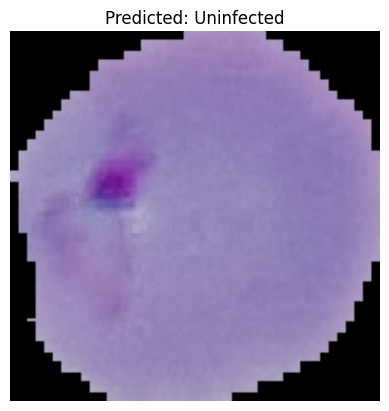

Swetha S 212222230155
The model predicts the image is: Uninfected


In [28]:
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, image_shape):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=image_shape[:2])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale to match training

    # Predict the class
    prediction = model.predict(img_array)
    class_label = "Parasitized" if prediction > 0.5 else "Uninfected"

    # Display the image and prediction
    plt.imshow(img)
    plt.title(f"Predicted: {class_label}")
    plt.axis('off')
    plt.show()
    return class_label

# Test the function with an example image from the dataset
sample_image_path = train_path + '/parasitized/' + os.listdir(train_path + '/parasitized')[200]  # Change this as needed
predicted_class = predict_image(model, sample_image_path, image_shape)
print(f"Swetha S 212222230155")
print(f"The model predicts the image is: {predicted_class}")


In [31]:
from tensorflow.keras.preprocessing import image

def predict_image(model, img_path, image_shape):
    # Load and preprocess the image
    img = image.load_img(img_path, target_size=image_shape[:2])
    img_array = image.img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
    img_array /= 255.0  # Rescale to match training

    # Predict the class
    prediction = model.predict(img_array)
    predicted_class = "Parasitized" if prediction > 0.9 else "Uninfected"

    # Get the actual class from the file path
    actual_class = "Parasitized" if "parasitized" in img_path.lower() else "Uninfected"

    # Display the image and prediction results
    plt.imshow(img)
    plt.title(f"Actual: {actual_class} | Predicted: {predicted_class}")
    plt.axis('off')
    plt.show()
    
    return actual_class, predicted_class

# Test the function with an example image from the dataset
# Path to the uploaded image
uploaded_image_path = ''

# Use the predict_image function on the uploaded image
actual, predicted = predict_image(model, uploaded_image_path, image_shape)
print(f"Actual class: {actual}")
print(f"Predicted class: {predicted}")

print("Swetha S \n212222230155")



FileNotFoundError: [Errno 2] No such file or directory: 'http://gpu3.saveetha.in/user/22008664/view/dataset/cell_images/test/parasitized/C100P61ThinF_IMG_20150918_144348_cell_144.png'